In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import re
from tqdm import tqdm


In [2]:
AUDIO_PATH = "../AUDIO_DATA"
AUDIO_LIST = sorted(os.listdir(AUDIO_PATH))
set([re.split('_|%',i)[3] for i in AUDIO_LIST])
print(AUDIO_LIST)

['20240929_023338_Dona_75-85%output.wav', '20240929_023344_Dona_75-85%output.wav', '20240929_023348_Dona_75-85%output.wav', '20240929_023353_Dona_75-85%output.wav', '20240929_023359_Dona_75-85%output.wav', '20240929_023409_Dona_75-85%output.wav', '20240929_023414_Dona_75-85%output.wav', '20240929_023418_Dona_75-85%output.wav', '20240929_023426_Dona_75-85%output.wav', '20240929_023431_Dona_75-85%output.wav', '20240929_023435_Dona_75-85%output.wav', '20240929_023439_Dona_75-85%output.wav', '20240929_023443_Dona_75-85%output.wav', '20240929_023447_Dona_75-85%output.wav', '20240929_023501_Dona_75-85%output.wav', '20240929_023505_Dona_75-85%output.wav', '20240929_023509_Dona_75-85%output.wav', '20240929_023513_Dona_75-85%output.wav', '20240929_023517_Dona_75-85%output.wav', '20240929_023521_Dona_75-85%output.wav', '20240929_023541_Dona_95-Ripeoutput.wav', '20240929_023702_Dona_95-Ripeoutput.wav', '20240929_023705_Dona_95-Ripeoutput.wav', '20240929_023710_Dona_95-Ripeoutput.wav', '20240929_0

In [3]:
from pathlib import Path
(Path(AUDIO_PATH)/AUDIO_LIST[0]).exists()

True

C:\Users\Tom\AppData\Local\Temp\ipykernel_15264\1617714703.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(AUDIO_PATH + '/' + AUDIO_LIST[0], sr=None)
c:\Users\Tom\Documents\Durian_internship\.venv\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\Tom\AppData\Local\Temp\ipykernel_15264\1617714703.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr1 = librosa.load(AUDIO_PATH + '/20240929_024435_Dona_95-Ripeoutput.wav', sr=None)
c:\Users\Tom\Documents\Durian_internship\.venv\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


0.0 22050.0 11025.0 40596009.521484375


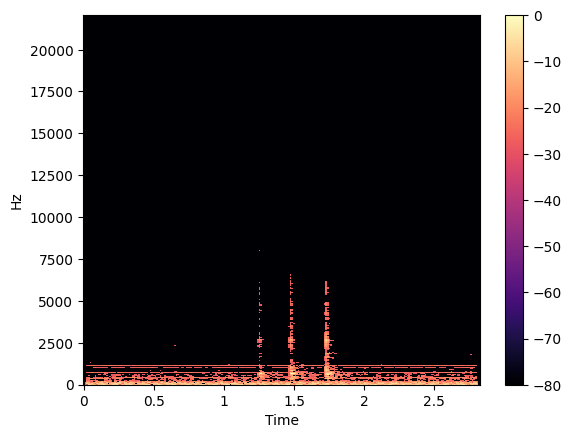

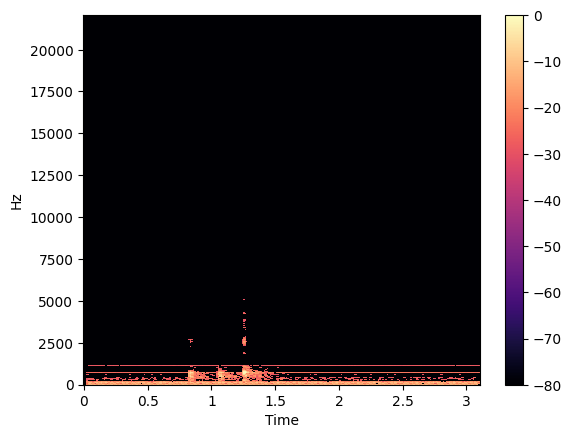

In [4]:
y, sr = librosa.load(AUDIO_PATH + '/' + AUDIO_LIST[0], sr=None)
x, sr1 = librosa.load(AUDIO_PATH + '/20240929_024435_Dona_95-Ripeoutput.wav', sr=None)
frequencies = librosa.fft_frequencies(sr=sr)
print(min(frequencies), max(frequencies), sum(frequencies)/len(frequencies), np.var(frequencies))


D = librosa.stft(y)
S_db1 = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db1_thresh = np.where(S_db1 > -30, S_db1, -80)
plt.figure()
librosa.display.specshow(S_db1_thresh, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

D2 = librosa.stft(x)
S_db2 = librosa.amplitude_to_db(np.abs(D2), ref=np.max)
S_db2_thresh = np.where(S_db2 > -30, S_db2, -80)
plt.figure()
librosa.display.specshow(S_db2_thresh, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

📍 Max pic = 0.00 dB à 646.00 Hz, time ≈ 1.49 s


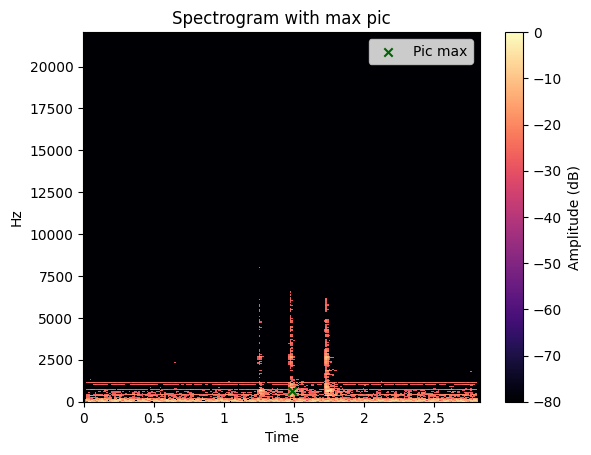

In [5]:
# Trouver l’indice du temps (colonne) du maximum global
time_index_max = np.argmax(np.max(S_db1_thresh, axis=0))

# Récupérer la colonne du spectrogramme à cet instant
column = S_db1_thresh[:, time_index_max]

# Trouver la fréquence où l’amplitude est maximale dans cette colonne
freq_index_max = np.argmax(column)

# Récupérer les vraies valeurs
freq_at_max = frequencies[freq_index_max]
time_at_max = time_index_max * 512 / sr  
val_db_max = column[freq_index_max]

print(f"📍 Max pic = {val_db_max:.2f} dB à {freq_at_max:.2f} Hz, time ≈ {time_at_max:.2f} s")

# Affichage
plt.figure()
librosa.display.specshow(S_db1_thresh, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(label='Amplitude (dB)')

# Ajouter le point du pic max en haut du pic
plt.scatter(time_at_max, freq_at_max, color='darkgreen', marker='x', label='Pic max')
plt.legend()
plt.title("Spectrogram with max pic")
plt.show()


In [6]:
def get_active_frequencies(S_db1_thresh, sr, n_fft=2048, threshold_db=-80):
    """
    Returns the frequencies (in Hz) that have at least one value above the threshold 
    in the thresholded spectrogram.

    Parameters:
        - S_db1_thresh: np.ndarray, the thresholded spectrogram
        - sr: sample rate
        - n_fft: FFT window size (must match the one used in STFT)
        - threshold_db: threshold value applied during thresholding (default is -80 dB)

    Returns:
        - List of active frequencies (in Hz)
    """
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    # Garder les lignes qui contiennent au moins une valeur > threshold
    active_freq_indices = np.where(np.any(S_db1_thresh > threshold_db, axis=1))[0]
    
    active_frequencies = frequencies[active_freq_indices]
    return active_frequencies.tolist()

active_freqs = get_active_frequencies(S_db1_thresh, sr=sr, n_fft=2048, threshold_db=-30)
print(max(active_freqs))

active_freqs2 = get_active_frequencies(S_db2_thresh, sr=sr, n_fft=2048, threshold_db=-30)
print(max(active_freqs2))

8010.3515625
5081.8359375


In [7]:
from collections import defaultdict

In [8]:
type_to_audio = defaultdict(list)

def tri_audio(audio_name):
    type_to_audio[re.split('_|%',audio_name)[3]].append(audio_name)
    

def load_audio(file_name,audio_path="../AUDIO_DATA"):
    y, sr = librosa.load(audio_path + '/' + file_name, sr=None)
    return y, sr

In [9]:
for i in AUDIO_LIST:
    tri_audio(i)


In [10]:
audios_75_85 = list(tqdm(map(load_audio,type_to_audio['75-85']),total=len(type_to_audio['75-85'])))
audios_95 = list(tqdm(map(load_audio,type_to_audio['95-Ripeoutput.wav']),total=len(type_to_audio['95-Ripeoutput.wav'])))

  0%|          | 0/45 [00:00<?, ?it/s]C:\Users\Tom\AppData\Local\Temp\ipykernel_15264\3379815566.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path + '/' + file_name, sr=None)
100%|██████████| 47/47 [00:03<00:00, 13.32it/s]


In [11]:
def extract_tresh(y):
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    S_db_thresh = np.where(S_db > -30, S_db, -80)
    return S_db_thresh

In [12]:
tresh_75_85 = [extract_tresh(i[0]) for i in audios_75_85] #type: ignore
tresh_95 = [extract_tresh(i[0]) for i in audios_95] #type: ignore

In [13]:
max_frequencies_75_85 = []
max_frequencies_95 = []

for i in range(len(tresh_75_85)):
    max_frequencies_75_85.append(max(get_active_frequencies(tresh_75_85[i], audios_75_85[i][1])))

for i in range(len(tresh_95)):
    max_frequencies_95.append(max(get_active_frequencies(tresh_95[i], audios_95[i][1])))


In [14]:
avg_75_85 = sum(max_frequencies_75_85)/len(max_frequencies_75_85)
avg_95 = sum(max_frequencies_75_85)/len(max_frequencies_95)
avg_75_85, avg_95

(5511.54296875, 5277.009225398936)

In [15]:
import statistics

statistics.median(max_frequencies_75_85), statistics.median(max_frequencies_95)

(5663.232421875, 4500.439453125)